## Cryptocurrency trading bot testing file.

### Install if needed.

In [1]:
##%pip install python-binance==0.7.5
#%pip install python-binance

### Examples loading directly from files.

In [2]:
import pandas as pd
crypto_exchange_info = 'crypto_logs/crypto_exchange_info.txt'
exchange_info = pd.read_csv(crypto_exchange_info, header=0, index_col=0)
exchange_info

,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,defaultSelfTradePreventionMode,allowedSelfTradePreventionModes,min_price,max_price,tick_size,step_size,multiplier_up
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,922327.0,1.000000e-06,0.0001,5.0
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0100,5.0
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,1000.0,1.000000e-06,0.1000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,HOOKBNB,HOOK,8,BNB,8,8,8,8,True,True,NONE,['NONE'],1.000000e-07,100.0,1.000000e-07,0.1000,5.0
1389,MAGICBTC,MAGIC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-08,1000.0,1.000000e-08,0.1000,5.0
1390,MAGICBUSD,MAGIC,8,BUSD,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0
1391,MAGICUSDT,MAGIC,8,USDT,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0


In [3]:
#import pandas as pd
#crypto_output_log_15s = 'crypto_logs/crypto_input_log_15s.txt'
#conversion_table = pd.read_csv(crypto_output_log_15s, header=[0], index_col=0)
#conversion_table.index = pd.DatetimeIndex(conversion_table.index)
#conversion_table

In [4]:
import pandas as pd
crypto_output_log_15s = 'crypto_logs/crypto_output_log_15s.txt'
df_15s = pd.read_csv(crypto_output_log_15s, header=[0, 1], index_col=0)
df_15s.index = pd.DatetimeIndex(df_15s.index)
df_15s

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-01-06 01:01:15,0.390,55.9,0.1158,0.00801,2.622,0.2740,0.1186,3.179439e-10,1.660901e-10,0.272,...,1.649676e+06,266512.064973,970569.456955,1.761469e+06,1.221223e+06,588930.658547,3.114427e+06,1.514733e+06,2.880573e+06,1.333305e+06
2023-01-06 01:01:30,0.390,55.9,0.1158,0.00801,2.622,0.2740,0.1186,3.179439e-10,1.660901e-10,0.272,...,1.649676e+06,266512.064973,970569.456955,1.761469e+06,1.221223e+06,588930.658547,3.114427e+06,1.514733e+06,2.880573e+06,1.333305e+06
2023-01-06 01:01:45,0.390,55.9,0.1158,0.00801,2.622,0.2740,0.1186,3.179439e-10,1.660901e-10,0.272,...,1.649676e+06,266512.064973,970569.456955,1.761469e+06,1.221223e+06,588930.658547,3.114427e+06,1.514733e+06,2.880573e+06,1.333305e+06
2023-01-06 01:02:00,0.390,55.9,0.1158,0.00801,2.620,0.2740,0.1186,3.173709e-10,1.655074e-10,0.272,...,1.648664e+06,266396.447673,971378.613955,1.761471e+06,1.220719e+06,588867.149047,3.114527e+06,1.517714e+06,2.880653e+06,1.333288e+06
2023-01-06 01:02:15,0.390,55.9,0.1158,0.00801,2.620,0.2740,0.1186,3.173709e-10,1.655074e-10,0.272,...,1.648664e+06,266396.447673,971378.613955,1.761471e+06,1.220719e+06,588867.149047,3.114527e+06,1.517714e+06,2.880653e+06,1.333288e+06
2023-01-06 01:02:30,0.390,55.9,0.1158,0.00801,2.620,0.2740,0.1186,3.173709e-10,1.655074e-10,0.272,...,1.648664e+06,266396.447673,971378.613955,1.761471e+06,1.220719e+06,588867.149047,3.114527e+06,1.517714e+06,2.880653e+06,1.333288e+06
2023-01-06 01:02:45,0.390,55.9,0.1158,0.00801,2.620,0.2740,0.1186,3.173709e-10,1.655074e-10,0.272,...,1.648664e+06,266396.447673,971378.613955,1.761471e+06,1.220719e+06,588867.149047,3.114527e+06,1.517714e+06,2.880653e+06,1.333288e+06
2023-01-06 01:03:00,0.390,55.9,0.1158,0.00801,2.616,0.2740,0.1186,3.173729e-10,1.655085e-10,0.272,...,1.647908e+06,266396.447673,973901.133955,1.761450e+06,1.220585e+06,588806.373148,3.109404e+06,1.516936e+06,2.881077e+06,1.331549e+06


### Load from logged files.

In [5]:
from crypto_logger import init_loggers
crypto_loggers = init_loggers()
crypto_loggers

{'input_5s': <utils.crypto_logger_input.Crypto_logger_input at 0x7f72d8850be0>,
 'output_5s': <utils.crypto_logger_output.Crypto_logger_output at 0x7f72ce2970a0>,
 'output_1min': <utils.crypto_logger_output.Crypto_logger_output at 0x7f731c16a130>}

In [6]:
input_5s = crypto_loggers['input_5s']
output_5s = crypto_loggers['output_5s']
output_1min = crypto_loggers['output_1min']
#output_30min = crypto_loggers['output_30min']
#output_1h = crypto_loggers['output_1h']
#output_1d = crypto_loggers['output_1d']

In [7]:
df_input_5s = input_5s.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_input_5s

In [8]:
df_output_5s = output_5s.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_output_5s

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-01-06 01:11:05,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:10,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:15,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:20,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:25,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:30,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:35,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06
2023-01-06 01:11:40,0.389,55.9,0.1157,0.008,2.622,0.2737,0.1186,3.174242e-10,1.655352e-10,0.272,...,1.647060e+06,265901.591716,984838.99353,1.721979e+06,1.217043e+06,586408.756355,3.093971e+06,1.518734e+06,2.873485e+06,1.325855e+06


In [9]:
import os
import yfinance as yf
num_cpus = os.cpu_count()
df_yf = yf.download(tickers=['SPY', 'BTC-USD', 'ETH-USD'], 
                    period='7d', 
                    interval='1m', 
                    group_by='ticker', 
                    prepost=True, 
                    auto_adjust=True, 
                    repair=True, 
                    keepna=True, 
                    threads=num_cpus)
df_yf = df_yf.rename(columns={
    'Open': 'open', 'High': 'high', 'Low': 'low', 
    'Close': 'close', 'Volume': 'volume'
})
df_yf.index.name = 'date'
df = df_yf.copy()
df

[*********************100%***********************]  3 of 3 completed


SPY                                      \
                                 open        high         low       close   
date                                                                        
2023-03-01 09:00:00+00:00  397.460000  397.610000  396.520000  397.530000   
2023-03-01 09:01:00+00:00  397.540000  397.860000  397.540000  397.800000   
2023-03-01 09:02:00+00:00  397.810000  397.930000  397.580000  397.580000   
2023-03-01 09:03:00+00:00  397.800000  397.930000  397.790000  397.800000   
2023-03-01 09:04:00+00:00  397.850000  397.970000  397.850000  397.910000   
...                               ...         ...         ...         ...   
2023-03-09 16:12:00+00:00  399.619995  399.720001  399.608490  399.690002   
2023-03-09 16:13:00+00:00  399.700012  399.714996  399.510010  399.549988   
2023-03-09 16:14:00+00:00  399.579987  399.799988  399.554993  399.760010   
2023-03-09 16:15:00+00:00  399.779999  399.829987  399.679993  399.799988   
2023-03-09 16:16:00+00:00  399.860809  399.860809  399.860809  399.860809   

                                          BTC-USD                              \
                             volume          open          high           low   
date                                                                            
2023-03-01 09:00:00+00:00       0.0           NaN           NaN           NaN   
2023-03-01 09:01:00+00:00       0.0           NaN           NaN           NaN   
2023-03-01 09:02:00+00:00       0.0           NaN           NaN           NaN   
2023-03-01 09:03:00+00:00       0.0           NaN           NaN           NaN   
2023-03-01 09:04:00+00:00       0.0           NaN           NaN           NaN   
...                             ...           ...           ...           ...   
2023-03-09 16:12:00+00:00  114199.0  21637.478516  21637.478516  21637.478516   
2023-03-09 16:13:00+00:00  145692.0           NaN           NaN           NaN   
2023-03-09 16:14:00+00:00   88571.0           NaN           NaN           NaN   
2023-03-09 16:15:00+00:00  382786.0           NaN           NaN           NaN   
2023-03-09 16:16:00+00:00       0.0           NaN           NaN           NaN   

                                                    ETH-USD               \
                                  close volume         open         high   
date                                                                       
2023-03-01 09:00:00+00:00           NaN    NaN          NaN          NaN   
2023-03-01 09:01:00+00:00           NaN    NaN          NaN          NaN   
2023-03-01 09:02:00+00:00           NaN    NaN          NaN          NaN   
2023-03-01 09:03:00+00:00           NaN    NaN          NaN          NaN   
2023-03-01 09:04:00+00:00           NaN    NaN          NaN          NaN   
...                                 ...    ...          ...          ...   
2023-03-09 16:12:00+00:00  21637.478516    0.0  1534.330688  1534.330688   
2023-03-09 16:13:00+00:00           NaN    NaN          NaN          NaN   
2023-03-09 16:14:00+00:00           NaN    NaN          NaN          NaN   
2023-03-09 16:15:00+00:00           NaN    NaN          NaN          NaN   
2023-03-09 16:16:00+00:00           NaN    NaN          NaN          NaN   

                                                               
                                   low        close    volume  
date                                                           
2023-03-01 09:00:00+00:00          NaN          NaN       NaN  
2023-03-01 09:01:00+00:00          NaN          NaN       NaN  
2023-03-01 09:02:00+00:00          NaN          NaN       NaN  
2023-03-01 09:03:00+00:00          NaN          NaN       NaN  
2023-03-01 09:04:00+00:00          NaN          NaN       NaN  
...                                ...          ...       ...  
2023-03-09 16:12:00+00:00  1534.330688  1534.330688  794112.0  
2023-03-09 16:13:00+00:00          NaN          NaN       NaN  
2023-03-09 16:14:00+00:00          NaN          NaN

In [10]:
df = df_yf.copy()

#s_open = df.xs('open', axis='columns', level=1).copy()
#s_close = df.xs('close', axis='columns', level=1).copy()
#s = pd.concat([s_open, s_close])
#s_open.iloc[0::2] = s_open.iloc[:]
#s = 
#df = 

#print(df.isna().sum().sum())
#df
#s
#s_open
#df = df.loc[:,(slice(None), ['open', 'close'])].copy()
#df_open = df.loc[:,(slice(None), ['open'])].copy()
#df_close = df.loc[:,(slice(None), ['close'])].copy()
#df
#df_open.groupby(by='open', axis='columns', level=1) #.apply(lambda s: s, axis='columns')
#df_open.T
df = df['BTC-USD'].copy()
#df = df['SPY'].copy()
s = pd.concat([df['open'], df['close']]).sort_index(kind='merge').fillna(method='pad').fillna(method='backfill')
df['open'] = s.iloc[0::2]
df['close'] = s.iloc[1::2]
df.tail(50)

,open,high,low,close,volume
date,,,,,
2023-03-09 15:27:00+00:00,21696.607422,NaN,NaN,21696.607422,0.0
2023-03-09 15:28:00+00:00,21719.373047,21719.373047,21719.373047,21719.373047,0.0
2023-03-09 15:29:00+00:00,21720.447266,21720.447266,21720.447266,21720.447266,0.0
2023-03-09 15:30:00+00:00,21720.494141,21720.494141,21720.494141,21720.494141,348160.0
2023-03-09 15:31:00+00:00,21721.763672,21721.763672,21721.763672,21721.763672,0.0
2023-03-09 15:32:00+00:00,21725.798828,21725.798828,21725.798828,21725.798828,0.0
2023-03-09 15:33:00+00:00,21725.611328,21725.611328,21725.611328,21725.611328,0.0
2023-03-09 15:34:00+00:00,21733.707031,21733.707031,21733.707031,21733.707031,0.0
2023-03-09 15:35:00+00:00,21733.496094,21733.496094,21733.496094,21733.496094,0.0


In [11]:
from utils.ohlcv_cleaning import clean_data
df = df_yf.copy()
df = clean_data(df)
print(df.isna().sum().sum())
df

0


symbol                            SPY                                      \
feature                          open        high         low       close   
date                                                                        
2023-03-01 09:00:00+00:00  397.460000  397.610000  396.520000  397.530000   
2023-03-01 09:01:00+00:00  397.540000  397.860000  397.540000  397.800000   
2023-03-01 09:02:00+00:00  397.810000  397.930000  397.580000  397.580000   
2023-03-01 09:03:00+00:00  397.800000  397.930000  397.790000  397.800000   
2023-03-01 09:04:00+00:00  397.850000  397.970000  397.850000  397.910000   
...                               ...         ...         ...         ...   
2023-03-09 16:12:00+00:00  399.619995  399.720001  399.608490  399.690002   
2023-03-09 16:13:00+00:00  399.700012  399.714996  399.510010  399.549988   
2023-03-09 16:14:00+00:00  399.579987  399.799988  399.554993  399.760010   
2023-03-09 16:15:00+00:00  399.779999  399.829987  399.679993  399.799988   
2023-03-09 16:16:00+00:00  399.860809  399.860809  399.860809  399.860809   

symbol                                    BTC-USD                              \
feature                      volume          open          high           low   
date                                                                            
2023-03-01 09:00:00+00:00       0.0  23476.632812  23476.632812  23476.632812   
2023-03-01 09:01:00+00:00       0.0  23476.632812  23476.632812  23476.632812   
2023-03-01 09:02:00+00:00       0.0  23476.632812  23476.632812  23476.632812   
2023-03-01 09:03:00+00:00       0.0  23476.632812  23476.632812  23476.632812   
2023-03-01 09:04:00+00:00       0.0  23476.632812  23476.632812  23476.632812   
...                             ...           ...           ...           ...   
2023-03-09 16:12:00+00:00  114199.0  21637.478516  21637.478516  21637.478516   
2023-03-09 16:13:00+00:00  145692.0  21637.478516  21637.478516  21637.478516   
2023-03-09 16:14:00+00:00   88571.0  21637.478516  21637.478516  21637.478516   
2023-03-09 16:15:00+00:00  382786.0  21637.478516  21637.478516  21637.478516   
2023-03-09 16:16:00+00:00       0.0  21637.478516  21637.478516  21637.478516   

symbol                                              ETH-USD               \
feature                           close volume         open         high   
date                                                                       
2023-03-01 09:00:00+00:00  23476.632812    0.0  1647.557739  1647.557739   
2023-03-01 09:01:00+00:00  23476.632812    0.0  1647.557739  1647.557739   
2023-03-01 09:02:00+00:00  23476.632812    0.0  1647.557739  1647.557739   
2023-03-01 09:03:00+00:00  23476.632812    0.0  1647.557739  1647.557739   
2023-03-01 09:04:00+00:00  23476.632812    0.0  1647.557739  1647.557739   
...                                 ...    ...          ...          ...   
2023-03-09 16:12:00+00:00  21637.478516    0.0  1534.330688  1534.330688   
2023-03-09 16:13:00+00:00  21637.478516    0.0  1534.330688  1534.330688   
2023-03-09 16:14:00+00:00  21637.478516    0.0  1534.330688  1534.330688   
2023-03-09 16:15:00+00:00  21637.478516    0.0  1534.330688  1534.330688   
2023-03-09 16:16:00+00:00  21637.478516    0.0  1534.330688  1534.330688   

symbol                                                         
feature                            low        close    volume  
date                                                           
2023-03-01 09:00:00+00:00  1647.557739  1647.557739       0.0  
2023-03-01 09:01:00+00:00  1647.557739  1647.557739       0.0  
2023-03-01 09:02:00+00:00  1647.557739  1647.557739       0.0  
2023-03-01 09:03:00+00:00  1647.557739  1647.557739       0.0  
2023-03-01 09:04:00+00:00  1647.557739  1647.557739       0.0  
...                                ...          ...       ...  
2023-03-09 16:12:00+00:00  1534.330688  1534.330688  794112.0  
2023-03-09 16:13:00+00:00  1534.330688  1534.330688       0.0  
2023-03-09 16:14:

In [12]:
len(df.columns.tolist())

15

In [13]:
len(df.dropna(axis='columns').columns.tolist())

15

In [14]:
df.dropna(axis='columns').columns.tolist()

[('SPY', 'open'),
 ('SPY', 'high'),
 ('SPY', 'low'),
 ('SPY', 'close'),
 ('SPY', 'volume'),
 ('BTC-USD', 'open'),
 ('BTC-USD', 'high'),
 ('BTC-USD', 'low'),
 ('BTC-USD', 'close'),
 ('BTC-USD', 'volume'),
 ('ETH-USD', 'open'),
 ('ETH-USD', 'high'),
 ('ETH-USD', 'low'),
 ('ETH-USD', 'close'),
 ('ETH-USD', 'volume')]

In [15]:
df_output_1min = output_1min.maybe_get_from_file(dataset=None, inputs=False, screened=False)
df_output_1min

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-01-05 00:17:00,0.397,56.8,0.1160,0.00808,2.445,0.2682,0.1161,3.195610e-10,1.713416e-10,0.276,...,1.748261e+06,348076.998619,444813.517059,2.067363e+06,2.425045e+06,2.677755e+06,5.562990e+06,1.671940e+06,2.272845e+06,8.197644e+05
2023-01-05 00:18:00,0.397,57.0,0.1160,0.00810,2.442,0.2686,0.1162,3.194572e-10,1.712860e-10,0.276,...,1.748347e+06,348091.870763,444882.752459,2.069568e+06,2.427796e+06,2.678650e+06,5.564408e+06,1.680078e+06,2.273577e+06,8.220117e+05
2023-01-05 00:19:00,0.397,57.0,0.1159,0.00810,2.447,0.2685,0.1162,3.194178e-10,1.712648e-10,0.276,...,1.755410e+06,348091.870763,444882.752459,2.069837e+06,2.427796e+06,2.681903e+06,5.564823e+06,1.681015e+06,2.276364e+06,8.252375e+05
2023-01-05 00:20:00,0.397,56.9,0.1159,0.00811,2.448,0.2686,0.1161,3.193866e-10,1.712481e-10,0.276,...,1.755423e+06,348101.971763,444882.752459,2.069837e+06,2.427817e+06,2.682015e+06,5.566428e+06,1.683262e+06,2.277890e+06,8.254139e+05
2023-01-05 00:21:00,0.397,56.8,0.1159,0.00811,2.450,0.2687,0.1161,3.195061e-10,1.719049e-10,0.276,...,1.758012e+06,348101.971763,444882.752459,2.069837e+06,2.428755e+06,2.682523e+06,5.568114e+06,1.684677e+06,2.277951e+06,8.254139e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-06 01:12:00,0.389,55.9,0.1157,0.00800,2.622,0.2745,0.1186,3.173624e-10,1.655030e-10,0.272,...,1.650674e+06,265901.591716,984820.868330,1.727167e+06,1.217025e+06,5.863533e+05,3.098744e+06,1.513932e+06,2.873627e+06,1.325756e+06
2023-01-06 01:13:00,0.389,55.9,0.1157,0.00800,2.622,0.2747,0.1186,3.173276e-10,1.654848e-10,0.272,...,1.642846e+06,265901.591716,984905.081630,1.726065e+06,1.217043e+06,5.848359e+05,3.097114e+06,1.506868e+06,2.872302e+06,1.325164e+06


In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# File:        utils/ohlcv_cleaning.py
# By:          Samuel Duclos
# For          Myself
# Description: Provides whole market OHLCV data cleaning.

# Library imports.
import pandas as pd

# Function definitions.
def clean_data(data):
    def clean_ticker(data, main_ticker, volume_columns=None, 
                     rolling_volume_columns=None):
        df = data[main_ticker].copy()
        data = data.sort_index(axis='columns')
        data = data.drop(columns=[main_ticker])
        if volume_columns is not None and len(volume_columns) > 0:
            df[volume_columns] = df[volume_columns].fillna(value=0.0)
        if rolling_volume_columns is not None and \
                len(rolling_volume_columns) > 0:
            df[rolling_volume_columns] = \
                df[rolling_volume_columns].fillna(method='pad').fillna(method='backfill')

        s = pd.concat([df['open'], df['close']])
        s = s.sort_index(kind='merge')
        s = s.fillna(method='pad')
        s = s.fillna(method='backfill')
        df['open'] = s.iloc[0::2]
        df['close'] = s.iloc[1::2]
        df.loc[df['high'].isna(),'high'] = \
            df.loc[df['high'].isna(),['open', 'high', 'low', 'close']].max(axis='columns')
        df.loc[df['low'].isna(),'low'] = \
            df.loc[df['low'].isna(),['open', 'high', 'low', 'close']].min(axis='columns')

        column_names = df.columns.tolist()
        columns = [(main_ticker, column) for column in column_names]
        df.columns = pd.MultiIndex.from_tuples(columns)
        df.columns = df.columns.set_names(['symbol', 'feature'])
        data = pd.concat([data, df], axis='columns')
        return data
    data.columns = data.columns.set_names(['symbol', 'feature'])
    columns = data.columns.tolist()
    tickers_list = data.columns.get_level_values('symbol').unique().tolist()
    features_list = data.columns.get_level_values('feature').unique().tolist()
    volume_columns = [feature for feature in features_list if feature.endswith('volume')]
    rolling_volume_columns = [feature for feature in volume_columns if feature.startswith('rolling_')]
    volume_columns = [feature for feature in volume_columns if not feature.startswith('rolling_')]
    for main_ticker in tickers_list:
        data = clean_ticker(data, main_ticker, volume_columns=volume_columns, 
                            rolling_volume_columns=rolling_volume_columns)
    #data = data.fillna(method='pad').fillna(method='backfill')
    data = data[columns]
    return data

df = df_output_1min.copy()
df = clean_data(df)
df2 = df_output_1min.copy()
import numpy as np
np.allclose(df, df2)

True

In [17]:
df

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
feature,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-01-05 00:17:00,0.397,56.8,0.1160,0.00808,2.445,0.2682,0.1161,3.195610e-10,1.713416e-10,0.276,...,1.748261e+06,348076.998619,444813.517059,2.067363e+06,2.425045e+06,2.677755e+06,5.562990e+06,1.671940e+06,2.272845e+06,8.197644e+05
2023-01-05 00:18:00,0.397,57.0,0.1160,0.00810,2.442,0.2686,0.1162,3.194572e-10,1.712860e-10,0.276,...,1.748347e+06,348091.870763,444882.752459,2.069568e+06,2.427796e+06,2.678650e+06,5.564408e+06,1.680078e+06,2.273577e+06,8.220117e+05
2023-01-05 00:19:00,0.397,57.0,0.1159,0.00810,2.447,0.2685,0.1162,3.194178e-10,1.712648e-10,0.276,...,1.755410e+06,348091.870763,444882.752459,2.069837e+06,2.427796e+06,2.681903e+06,5.564823e+06,1.681015e+06,2.276364e+06,8.252375e+05
2023-01-05 00:20:00,0.397,56.9,0.1159,0.00811,2.448,0.2686,0.1161,3.193866e-10,1.712481e-10,0.276,...,1.755423e+06,348101.971763,444882.752459,2.069837e+06,2.427817e+06,2.682015e+06,5.566428e+06,1.683262e+06,2.277890e+06,8.254139e+05
2023-01-05 00:21:00,0.397,56.8,0.1159,0.00811,2.450,0.2687,0.1161,3.195061e-10,1.719049e-10,0.276,...,1.758012e+06,348101.971763,444882.752459,2.069837e+06,2.428755e+06,2.682523e+06,5.568114e+06,1.684677e+06,2.277951e+06,8.254139e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-06 01:12:00,0.389,55.9,0.1157,0.00800,2.622,0.2745,0.1186,3.173624e-10,1.655030e-10,0.272,...,1.650674e+06,265901.591716,984820.868330,1.727167e+06,1.217025e+06,5.863533e+05,3.098744e+06,1.513932e+06,2.873627e+06,1.325756e+06
2023-01-06 01:13:00,0.389,55.9,0.1157,0.00800,2.622,0.2747,0.1186,3.173276e-10,1.654848e-10,0.272,...,1.642846e+06,265901.591716,984905.081630,1.726065e+06,1.217043e+06,5.848359e+05,3.097114e+06,1.506868e+06,2.872302e+06,1.325164e+06


In [18]:
df2

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
pair,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-01-05 00:17:00,0.397,56.8,0.1160,0.00808,2.445,0.2682,0.1161,3.195610e-10,1.713416e-10,0.276,...,1.748261e+06,348076.998619,444813.517059,2.067363e+06,2.425045e+06,2.677755e+06,5.562990e+06,1.671940e+06,2.272845e+06,8.197644e+05
2023-01-05 00:18:00,0.397,57.0,0.1160,0.00810,2.442,0.2686,0.1162,3.194572e-10,1.712860e-10,0.276,...,1.748347e+06,348091.870763,444882.752459,2.069568e+06,2.427796e+06,2.678650e+06,5.564408e+06,1.680078e+06,2.273577e+06,8.220117e+05
2023-01-05 00:19:00,0.397,57.0,0.1159,0.00810,2.447,0.2685,0.1162,3.194178e-10,1.712648e-10,0.276,...,1.755410e+06,348091.870763,444882.752459,2.069837e+06,2.427796e+06,2.681903e+06,5.564823e+06,1.681015e+06,2.276364e+06,8.252375e+05
2023-01-05 00:20:00,0.397,56.9,0.1159,0.00811,2.448,0.2686,0.1161,3.193866e-10,1.712481e-10,0.276,...,1.755423e+06,348101.971763,444882.752459,2.069837e+06,2.427817e+06,2.682015e+06,5.566428e+06,1.683262e+06,2.277890e+06,8.254139e+05
2023-01-05 00:21:00,0.397,56.8,0.1159,0.00811,2.450,0.2687,0.1161,3.195061e-10,1.719049e-10,0.276,...,1.758012e+06,348101.971763,444882.752459,2.069837e+06,2.428755e+06,2.682523e+06,5.568114e+06,1.684677e+06,2.277951e+06,8.254139e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-06 01:12:00,0.389,55.9,0.1157,0.00800,2.622,0.2745,0.1186,3.173624e-10,1.655030e-10,0.272,...,1.650674e+06,265901.591716,984820.868330,1.727167e+06,1.217025e+06,5.863533e+05,3.098744e+06,1.513932e+06,2.873627e+06,1.325756e+06
2023-01-06 01:13:00,0.389,55.9,0.1157,0.00800,2.622,0.2747,0.1186,3.173276e-10,1.654848e-10,0.272,...,1.642846e+06,265901.591716,984905.081630,1.726065e+06,1.217043e+06,5.848359e+05,3.097114e+06,1.506868e+06,2.872302e+06,1.325164e+06


In [19]:
#df_output_30min = output_30min.maybe_get_from_file(dataset=None, inputs=False, screened=False)
#df_output_30min

In [20]:
#df_output_1h = output_1h.maybe_get_from_file(dataset=None, inputs=False, screened=False)
#df_output_1h

In [21]:
#df_output_1d = output_1d.maybe_get_from_file(dataset=None, inputs=False, screened=False)
#df_output_1d

In [22]:
df_input_5s_screened = input_5s.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_input_5s_screened

In [23]:
df_output_5s_screened = output_5s.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_output_5s_screened

In [24]:
df_output_1min_screened = output_1min.maybe_get_from_file(dataset=None, inputs=False, screened=True)
df_output_1min_screened

In [25]:
#df_output_30min_screened = output_30min.maybe_get_from_file(dataset=None, inputs=False, screened=True)
#df_output_30min_screened

In [26]:
#df_output_1h_screened = output_1h.maybe_get_from_file(dataset=None, inputs=False, screened=True)
#df_output_1h_screened

In [27]:
#df_output_1d_screened = output_1d.maybe_get_from_file(dataset=None, inputs=False, screened=True)
#df_output_1d_screened

### Uncomment to start logger.

In [28]:
#from crypto_logger import loop_loggers
#loop_loggers(crypto_loggers)

### Test indicators individually.

In [29]:
import pandas_ta as ta

def filter_in_market(function, dataset):
    def f(x):
        x = x.loc[:,~x.columns.duplicated()]
        return function(x)
    tickers_list = dataset.columns.get_level_values(0).unique().tolist()
    return pd.Series([ticker for ticker in tickers_list if f(dataset[ticker])], dtype='str')

def get_relative_volume_levels_smoothed_trigger(data, average1=26, average2=14, threshold=0.2):
    volume = data['volume']
    volume_average = ta.sma(close=volume, length=average1)
    relative_volume = volume / volume_average
    smoothed_relative_volume = ta.sma(close=relative_volume, length=average2)
    return (smoothed_relative_volume > threshold).iat[-1]

def get_relative_volume_levels_at_time_smoothed_thresholded(data):
    try:
        volume = data['volume']
        #volume = volume.groupby(pd.Grouper(freq='D')).cumsum()
        cum_volume = volume.groupby(pd.Grouper(freq='24h')).cumsum()
        #volume = volume.groupby(pd.Grouper(freq='60m')).cumsum()
        cum_rvol = (cum_volume / cum_volume.shift(1)).fillna(method='pad')
        rvol = (volume / volume.shift(1)).fillna(method='pad')
        bar_up = (data['close'] > data['open'])
        bar_up |= (data['close'] == data['open']) & (data['close'].diff() > 0)
        bar_up = bar_up.astype(int)
        bar_up = bar_up * 2 - 1
        #rvol *= bar_up
        cum_rvol_dir = cum_rvol * bar_up
        rvol_dir = rvol * bar_up
        rvol_indicator = ta.hma(rvol, length=14, talib=True)
        rvol_dir_indicator = ta.hma(rvol_dir, length=14, talib=True)
        cum_rvol_indicator = ta.hma(cum_rvol, length=14, talib=True)
        cum_rvol_dir_indicator = ta.hma(cum_rvol_dir, length=14, talib=True)
        rvol_indicator = rvol_indicator.rename('relative_volume_levels_smoothed')
        rvol_dir_indicator = rvol_dir_indicator.rename('relative_volume_levels_dir_smoothed')
        cum_rvol_indicator = cum_rvol_indicator.rename('cum_relative_volume_levels_smoothed')
        cum_rvol_dir_indicator = cum_rvol_dir_indicator.rename('cum_relative_volume_levels_dir_smoothed')
        #threshold = (ta.sma(rvol, length=100, talib=True) + ta.stdev(rvol, length=100, talib=True))
        threshold_dir = 0
        threshold = 2
        rvol_thresholded = (rvol_indicator > threshold).iat[-1]
        rvol_dir_thresholded = (rvol_dir_indicator > threshold_dir).iat[-1]
        cum_rvol_thresholded = (cum_rvol_indicator > threshold).iat[-1]
        cum_rvol_dir_thresholded = (cum_rvol_dir_indicator > threshold_dir).iat[-1]
        trigger = (rvol_thresholded | rvol_dir_thresholded | cum_rvol_thresholded | cum_rvol_dir_thresholded)
    except Exception as e:
        print('rvol exception:', e)
        trigger = False
    return trigger

def get_positive_trend_strength_trigger(data):
    ADX = data.ta.adx(talib=True)
    return (ADX['ADX_14'] < 0.20).iloc[-3] & (ADX['ADX_14'] > 0.20).iat[-2]

def get_not_negative_trend_strength_trigger(data):
    ADX = data.ta.adx(length=14, lensig=8, talib=True)
    return ((ADX['DMP_14'] > ADX['DMN_14']) & (ADX['ADX_14'] > 0.30)).iat[-1]

def get_not_negative_rebound_trigger(data):
    CCI = data.ta.cci(length=22, talib=True)
    MFI = data.ta.mfi(length=11, talib=True)
    return ((CCI > 0) | (MFI > 20)).iat[-1]

def get_positive_choppiness_trigger(data):
    CHOP = data.ta.chop(talib=True)
    return CHOP.iat[-1] < 38.2

def get_positive_phase_trigger(data):
    MACD = data.ta.macd(talib=True)
    histogram = MACD['MACDs_12_26_9'] - MACD['MACD_12_26_9']
    return ((histogram > histogram.shift(1)) | \
            (MACD['MACD_12_26_9'] > MACD['MACDs_12_26_9'])).iat[-1]

def get_positive_phase_trigger(data):
    MACD = data.ta.macd(talib=True)
    histogram = MACD['MACDs_12_26_9'] - MACD['MACD_12_26_9']
    return ((histogram.iloc[-2] > histogram.iat[-2]) or \
            (MACD['MACD_12_26_9'].iat[-1] > MACD['MACDs_12_26_9'].iat[-1]))

def get_not_square_wave_triggers(data, multiplications=10):
    multiplications = min(data.shape[0] // 5, multiplications)
    triggers = True
    for multiplier in range(1, multiplications + 1):
        period = -5 * multiplier
        uniques = 2 * multiplier
        square_wave_trigger = (data.iloc[period:]['close'].unique().size < uniques)
        if square_wave_trigger:
            triggers = False
            break
    return triggers

def get_minute_not_square_wave_triggers(data):
    return get_not_square_wave_triggers(data, multiplications=10)

def get_hourly_not_square_wave_triggers(data):
    return get_not_square_wave_triggers(data, multiplier_schedule=[1])

def get_daily_not_square_wave_triggers(data):
    return get_not_square_wave_triggers(data, multiplier_schedule=[1])

def get_daily_volume_minimum_trigger(data):
    return (data['volume'] > 1000000).iat[-1]

def get_daily_volume_change_trigger(data):
    return ((data['volume'].pct_change(1) * 100) > 300).iat[-1]

def get_minute_daily_volume_minimum_trigger(data):
    return (data['rolling_base_volume'] > 1000000).iat[-1]

def get_minute_daily_volume_change_trigger(data):
    #return ((data['rolling_base_volume'].pct_change(1440) * 100) > 300).iat[-1]
    return ((data['rolling_base_volume'].pct_change(1440) * 100) > 0).iat[-1]

def get_rising_volume_trigger(data):
    return (data['rolling_base_volume'].diff(1) > 0).iat[-1]

In [30]:
#if df_output_1d is not None:
#    df = df_output_1d.copy()
#    df.columns = df.columns.swaplevel(0, 1)
#    df = df.rename(columns={'base_volume': 'volume'})
#    df.columns = df.columns.swaplevel(0, 1)
#    filtered_1 = set(filter_in_market(get_daily_not_square_wave_triggers, df).tolist())
#    filtered_2 = set(filter_in_market(get_daily_volume_minimum_trigger, df).tolist())
#    filtered_3 = set(filter_in_market(get_relative_volume_levels_smoothed_trigger, df).tolist())
#    filtered_1d = pd.Series(list(filtered_1 & filtered_2 & filtered_3))
#    filtered_1d

In [31]:
#if df_output_1h is not None:
#    df = df_output_1h.copy()
#    df.columns = df.columns.swaplevel(0, 1)
#    df = df.rename(columns={'base_volume': 'volume'})
#    df.columns = df.columns.swaplevel(0, 1)
#    filtered_1 = set(filter_in_market(get_hourly_not_square_wave_triggers, df).tolist())
#    filtered_2 = set(filter_in_market(get_relative_volume_levels_at_time_smoothed_thresholded, df).tolist())
#    filtered_1h = pd.Series(list(filtered_1 & filtered_2))
#    filtered_1h

In [32]:
from utils.indicators import filter_in_market, screen_one
if df_output_1min is not None:
    df = df_output_1min.copy()
    df.columns = df.columns.swaplevel(0, 1)
    df = df.rename(columns={'base_volume': 'volume'})
    df.columns = df.columns.swaplevel(0, 1)
    filtered = filter_in_market(screen_one, df).tolist()
    filtered

In [33]:
if df_output_1min is not None:
    df = df_output_1min.copy()
    df.columns = df.columns.swaplevel(0, 1)
    df = df.rename(columns={'base_volume': 'volume'})
    df.columns = df.columns.swaplevel(0, 1)
    filtered_1 = set(filter_in_market(get_minute_not_square_wave_triggers, df).tolist())
    filtered_2 = set(filter_in_market(get_minute_daily_volume_minimum_trigger, df).tolist())
    filtered_3 = set(filter_in_market(get_minute_daily_volume_change_trigger, df).tolist())
    filtered_4 = set(filter_in_market(get_rising_volume_trigger, df).tolist())
    filtered_1min = pd.Series(list(filtered_1 & filtered_2 & filtered_3 & filtered_4))
    print(len(filtered_1min))
    print(filtered_1min)

0
Series([], dtype: float64)


/tmp/ipykernel_22662/1956331305.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filtered_1min = pd.Series(list(filtered_1 & filtered_2 & filtered_3 & filtered_4))


In [34]:
try:
    print(list(set(filtered_1h.tolist()) & set(filtered_1d.tolist())))
except NameError:
    pass

In [35]:
#try:
#    print(list(set(filtered_1min.tolist()) & set(filtered_1h.tolist())))
#except NameError:
#    pass

In [36]:
#try:
#    print(list(set(filtered_1min.tolist()) & set(filtered_1d.tolist())))
#except NameError:
#    pass

In [37]:
#try:
#    print(list(set(filtered_1min.tolist()) & set(filtered_1h.tolist()) & set(filtered_1d.tolist())))
#except NameError:
#    pass

### Conversion tests.

In [38]:
# Time initialization from here.
import time
t1 = time.time()

# Import libraries.
from utils.authentication import Cryptocurrency_authenticator
from utils.exchange import Cryptocurrency_exchange
from utils.conversion import precompute_shortest_paths

# Manage API keys.
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info

# Pre-compute pair paths.
shortest_paths = precompute_shortest_paths(exchange_info, 
                                   priority=None, 
                                   shortest_paths_file='crypto_logs/shortest_paths.pkl')

# Print elapsed time from the beginning of the initialization until now.
t2 = time.time()
print('Elapsed time:', t2 - t1)

# Display pre-computed exchange info.
exchange_info

Elapsed time: 1.0577208995819092


,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,defaultSelfTradePreventionMode,allowedSelfTradePreventionModes,min_price,max_price,tick_size,step_size,multiplier_up
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,922327.0,1.000000e-06,0.0001,5.0
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0100,5.0
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,1000.0,1.000000e-06,0.1000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,HOOKBNB,HOOK,8,BNB,8,8,8,8,True,True,NONE,['NONE'],1.000000e-07,100.0,1.000000e-07,0.1000,5.0
1389,MAGICBTC,MAGIC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-08,1000.0,1.000000e-08,0.1000,5.0
1390,MAGICBUSD,MAGIC,8,BUSD,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0
1391,MAGICUSDT,MAGIC,8,USDT,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0


#### Example testing conversion_table directly (a bottleneck).

In [39]:
# Time initialization from here.
import time
t1 = time.time()

# Import libraries.
from utils.authentication import Cryptocurrency_authenticator
from utils.exchange import Cryptocurrency_exchange
from utils.conversion import precompute_shortest_paths
#from utils.conversion import get_timezone_offset_in_seconds
#from utils.conversion_table import get_conversion_table

# Manage API keys.
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info

shortest_paths = precompute_shortest_paths(exchange_info, 
                                   priority=None, 
                                   shortest_paths_file='crypto_logs/shortest_paths.pkl')

## Precalculate UTC offset for inter-server communication coherence.
#offset_s = get_timezone_offset_in_seconds()
#
## Precalculate conversion_table.
#conversion_table = get_conversion_table(client=client, 
#                                        exchange_info=exchange_info, 
#                                        offset_s=offset_s, 
#                                        dump_raw=False, 
#                                        as_pair=True, 
#                                        minimal=False, 
#                                        extra_minimal=True, 
#                                        super_extra_minimal=False, 
#                                        convert_to_USDT=False, 
#                                        shortest_paths=shortest_paths)
#
## Print elapsed time from the beginning of the initialization until now.
#t2 = time.time()
#print('Elapsed time:', t2 - t1)
#
## Display pre-computed conversion table.
#conversion_table.sort_values(by='rolling_base_volume', ascending=False).head(50)

In [40]:
# Library imports.
from typing import Dict, List, Tuple, Union, Optional
from binance.client import Client
from utils.conversion import convert_price
from utils.conversion import get_base_asset_from_pair, get_quote_asset_from_pair
import datetime
import pandas as pd

# Function definitions.
def get_conversion_table_from_binance(client: Client, 
                                      exchange_info: pd.DataFrame, 
                                      offset_s: float = 0, 
                                      dump_raw: bool = False) -> pd.DataFrame:
    conversion_table = pd.DataFrame(client.get_ticker())
    conversion_table = conversion_table[conversion_table['symbol'].isin(
        exchange_info['symbol'])]

    conversion_table['base_asset'] = conversion_table['symbol'].apply(
        lambda x: get_base_asset_from_pair(x, exchange_info=exchange_info))
    conversion_table['quote_asset'] = conversion_table['symbol'].apply(
        lambda x: get_quote_asset_from_pair(x, exchange_info=exchange_info))

    conversion_table = conversion_table.rename(columns={
        'openPrice': 'open', 'highPrice': 'high', 'lowPrice': 'low', 
        'lastPrice': 'close', 'lastQty': 'last_volume', 
        'volume': 'rolling_base_volume', 
        'quoteVolume': 'rolling_quote_volume', 
        'bidPrice': 'bid_price', 'askPrice': 'ask_price', 
        'bidQty': 'bid_volume', 'askQty': 'ask_volume', 'firstId': 'first_ID', 
        'lastId': 'last_ID', 'openTime': 'open_time', 'closeTime': 'date', 
        'prevClosePrice': 'close_shifted', 
        'weightedAvgPrice': 'weighted_average_price', 
        'priceChange': 'price_change', 
        'priceChangePercent': 'price_change_percent'})

    if dump_raw:
        conversion_table.to_csv('crypto_logs/conversion_table.txt')

    conversion_table[[
        'open', 'high', 'low', 'close', 'close_shifted', 
        'rolling_base_volume', 'rolling_quote_volume', 'bid_price', 
        'ask_price', 'bid_volume', 'ask_volume', 'price_change_percent']] = \
            conversion_table[[
                'open', 'high', 'low', 'close', 'close_shifted', 
                'rolling_base_volume', 'rolling_quote_volume', 'bid_price', 
                'ask_price', 'bid_volume', 'ask_volume', 
                'price_change_percent']].astype(float)

    conversion_table[['date', 'count']] = \
        conversion_table[['date', 'count']].astype(int)
    conversion_table['date'] = (conversion_table['date'] + offset_s * 1000)
    conversion_table['date'] /= 1000
    conversion_table['date'] = conversion_table['date'].apply(
        datetime.datetime.fromtimestamp)
    conversion_table['date'] = pd.DatetimeIndex(conversion_table['date'])
    return conversion_table.sort_values(by='date')

def process_conversion_table(conversion_table: pd.DataFrame, 
                             exchange_info: pd.DataFrame, 
                             as_pair: bool = False, 
                             minimal: bool = False, 
                             extra_minimal: bool = True, 
                             super_extra_minimal: bool = False, 
                             convert_to_USDT: bool = False, 
                             shortest_paths: Optional[Dict[str, Dict[str, 
                                             Dict[str, List[Tuple[str, 
                                                 str]]]]]] = None) -> \
        pd.DataFrame:
    """
    Fetches and calculates data used for prices, volumes and other stats.
    :param client: \
        object from python-binance useful for calling client.get_ticker().
    :param exchange_info: Pre-calculated exchange information on all tickers.
    :return: pd.DataFrame containing all preprocessed conversion table info.
    :column is_shorted: is the symbol made from inversion.
    :column symbol: concatenated string made from base_asset and quote_asset.
    :column shorted_symbol: symbol with inverted base_asset and quote_asset.
    :column base_asset: asset on the left.
    :column quote_asset: asset on the right.
    :column price_change: (close - open).
    :column price_change_percent: (((close - open) / open) * 100).
    :column USDT_price_change: (USDT_close - USDT_open).
    :column USDT_price_change_percent: \
        (((USDT_close - USDT_open) / USDT_open) * 100).
    :column weighted_average_price: weighted average price.
    :column close_shifted: close price of the previous day.
    :column open: open price of the day.
    :column high: high price of the day.
    :column low: low price of the day.
    :column close: close price of the day.
    :column last_volume: volume of the last price update.
    :column USDT_bid_price: USDT-converted bid price.
    :column USDT_ask_price: USDT-converted ask price.
    :column USDT_bid_volume: USDT-converted bid volume.
    :column USDT_ask_volume: USDT-converted ask volume.
    :column bid_price: price of the bid.
    :column bid_volume: volume of the bid at bid_price.
    :column ask_price: price of the ask.
    :column ask_volume: volume of the ask at ask_price.
    :column rolling_base_volume: rolling_base_volume given by the API.
    :column rolling_quote_volume: rolling_quote_volume given by the API.
    :column open_time: date minus 24 hours.
    :column date: time from epoch in milliseconds of the last price update.
    :column first_ID: transaction ID from 1 day ago.
    :column last_ID: latest transaction ID.
    :column count: value calculated by subtracting first_ID from last_ID.
    :column USDT_open: USDT-converted open price.
    :column USDT_high: USDT-converted high price.
    :column USDT_low: USDT-converted low price.
    :column USDT_price: USDT-converted close price.
    :column rolling_USDT_base_volume: USDT-converted rolling_base_volume.
    :column rolling_USDT_quote_volume: USDT-converted rolling_quote_volume.
    :column rolling_traded_volume: \
        sum by base_asset of all USDT-converted volumes.
    :column importance: \
        rolling_USDT_base_volume divided by rolling_traded_volume.
    :column traded_price: \
        sum by base_asset of all (close prices times importance).
    :column traded_bid_price: \
        sum by base_asset of all (bid prices times importance).
    :column traded_ask_price: \
        sum by base_asset of all (ask prices times importance).
    :column bid_ask_percent_change: \
        ((ask_price - bid_price) / ask_price) * 100).
    :column bid_ask_volume_percent_change: \
        ((bid_volume / (bid_volume + ask_volume)) * 100).
    :column traded_bid_ask_percent_change: \
        ((traded_ask_price - traded_bid_price) / traded_ask_price) * 100).
    :column traded_bid_ask_volume_percent_change: \
        ((traded_bid_volume / (traded_bid_volume + traded_ask_volume)) * 100).
    """
    if super_extra_minimal:
        extra_minimal = True

    if extra_minimal:
        minimal = True

    if as_pair:
        super_extra_minimal = False
    else:
        convert_to_USDT = True

    if minimal:
        conversion_table = conversion_table[[
            'symbol', 'base_asset', 'quote_asset', 'open', 'high', 'low', 
            'close', 'rolling_base_volume', 'rolling_quote_volume', 'count', 
            'bid_price', 'ask_price', 'bid_volume', 'ask_volume', 'date', 
            'price_change_percent']]

    conversion_table = conversion_table.copy()
    conversion_table['rolling_base_quote_volume'] = \
        conversion_table['rolling_quote_volume'] / conversion_table['close']

    if convert_to_USDT:
        if not extra_minimal:
            conversion_table['high_pre_conversion'] = \
                (((conversion_table['high'] - conversion_table['close']) / \
                  conversion_table['close']) + 1)
            conversion_table['low_pre_conversion'] = \
                (((conversion_table['low'] - conversion_table['close']) / \
                  conversion_table['close']) + 1)

        conversion_table['bid_pre_conversion'] = \
            (((conversion_table['bid_price'] - conversion_table['close']) / \
              conversion_table['close']) + 1)
        conversion_table['ask_pre_conversion'] = \
            (((conversion_table['ask_price'] - conversion_table['close']) / \
              conversion_table['close']) + 1)

        if not super_extra_minimal:
            temp_conversion_table = conversion_table[[
                'base_asset', 'open']]
            temp_conversion_table = temp_conversion_table.drop_duplicates(
                subset=['base_asset'], keep='first')
            conversion_table['USDT_open'] = \
                temp_conversion_table.apply(
                    lambda x: convert_price(
                        size=1, from_asset=x['base_asset'], 
                        to_asset='USDT', 
                        conversion_table=conversion_table, 
                        exchange_info=exchange_info, 
                        shortest_path=shortest_paths, 
                        key='open', priority='accuracy'), axis='columns')
            conversion_table['USDT_open'] = conversion_table[[
                'base_asset', 'USDT_open']].groupby(
                    by=['base_asset']).fillna(method='pad')['USDT_open']

        temp_conversion_table = conversion_table[[
            'base_asset', 'close']]
        temp_conversion_table = temp_conversion_table.drop_duplicates(
            subset=['base_asset'], keep='first')
        conversion_table['USDT_price'] = \
            temp_conversion_table.apply(
                lambda x: convert_price(
                    size=1, from_asset=x['base_asset'], 
                    to_asset='USDT', 
                    conversion_table=conversion_table, 
                    exchange_info=exchange_info, 
                    shortest_path=shortest_paths, 
                    key='close', priority='accuracy'), axis='columns')
        conversion_table['USDT_price'] = conversion_table[[
            'base_asset', 'USDT_price']].groupby(
                by=['base_asset']).fillna(method='pad')['USDT_price']

        if not extra_minimal:
            conversion_table['USDT_high'] = \
                conversion_table['USDT_price'].astype(float) * \
                conversion_table['high_pre_conversion']
            conversion_table['USDT_low'] = \
                conversion_table['USDT_price'].astype(float) * \
                conversion_table['low_pre_conversion']

        conversion_table['USDT_bid_price'] = \
            conversion_table['USDT_price'].astype(float) * \
            conversion_table['bid_pre_conversion']
        conversion_table['USDT_ask_price'] = \
            conversion_table['USDT_price'].astype(float) * \
            conversion_table['ask_pre_conversion']
        conversion_table['USDT_bid_volume'] = \
            conversion_table['bid_volume'] * \
            conversion_table['USDT_bid_price'].astype(float)
        conversion_table['USDT_ask_volume'] = \
            conversion_table['ask_volume'] * \
            conversion_table['USDT_ask_price'].astype(float)

        conversion_table['rolling_USDT_base_volume'] = \
            conversion_table['rolling_base_volume'] * \
            conversion_table['USDT_price'].astype(float)
        conversion_table['rolling_USDT_quote_volume'] = \
            conversion_table['rolling_base_quote_volume'] * \
            conversion_table['USDT_price'].astype(float)

        if super_extra_minimal:
            price_change_percent = conversion_table[[
                'base_asset', 'price_change_percent']].groupby(
                    by='base_asset').agg(lambda x: x.iloc[x.abs().argmax()])
            conversion_table['price_change_percent'] = \
                conversion_table.apply(
                    lambda x: price_change_percent.loc[x['base_asset']], 
                    axis='columns')
        else:
            conversion_table['USDT_price_change'] = \
                (conversion_table['USDT_price'].astype(float) - \
                 conversion_table['USDT_open'].astype(float))
            conversion_table['USDT_price_change_percent'] = \
                ((conversion_table['USDT_price_change'] / \
                  conversion_table['USDT_open'].astype(float)) * 100)

        conversion_table['is_shorted'] = False

        conversion_table_swapped = conversion_table.copy()
        conversion_table_swapped = \
            conversion_table_swapped.rename(columns={
                'ask_price': 'bid_price', 
                'bid_price': 'ask_price', 
                'ask_volume': 'bid_volume', 
                'bid_volume': 'ask_volume', 
                'rolling_base_volume': 'rolling_quote_volume', 
                'rolling_quote_volume': 'rolling_base_volume', 
                'base_asset': 'quote_asset', 
                'quote_asset': 'base_asset', 
                'rolling_USDT_base_volume': 
                    'rolling_USDT_quote_volume', 
                'rolling_USDT_quote_volume': 
                    'rolling_USDT_base_volume', 
                'USDT_ask_price': 'USDT_bid_price', 
                'USDT_bid_price': 'USDT_ask_price', 
                'USDT_ask_volume': 'USDT_bid_volume', 
                'USDT_bid_volume': 'USDT_ask_volume'})
        if minimal:
            if super_extra_minimal:
                conversion_table_swapped = conversion_table_swapped[[
                    'symbol', 'price_change_percent', 'close', 
                    'ask_price', 'ask_volume', 'bid_price', 'bid_volume', 
                    'open', 'rolling_quote_volume', 'rolling_base_volume', 
                    'date', 'count', 'quote_asset', 'base_asset', 
                    'USDT_price', 'rolling_USDT_quote_volume', 
                    'rolling_USDT_base_volume', 'is_shorted']]
            else:
                conversion_table_swapped = conversion_table_swapped[[
                    'symbol', 'price_change_percent', 'close', 
                    'ask_price', 'ask_volume', 'bid_price', 'bid_volume', 
                    'open', 'rolling_quote_volume', 'rolling_base_volume', 
                    'date', 'count', 'quote_asset', 'base_asset', 
                    'USDT_open', 'USDT_price', 
                    'rolling_USDT_quote_volume', 
                    'rolling_USDT_base_volume', 'USDT_ask_price', 
                    'USDT_bid_price', 'USDT_ask_volume', 
                    'USDT_bid_volume', 'USDT_price_change_percent', 
                    'is_shorted']]
        else:
            conversion_table_swapped = conversion_table_swapped[[
                'symbol', 'price_change', 'price_change_percent', 
                'weighted_average_price', 'close_shifted', 'close', 
                'last_volume', 'ask_price', 'ask_volume', 'bid_price', 
                'bid_volume', 'open', 'high', 'low', 'rolling_quote_volume', 
                'rolling_base_volume', 'open_time', 'date', 'first_ID', 
                'last_ID', 'count', 'quote_asset', 'base_asset', 'USDT_open', 
                'USDT_high', 'USDT_low', 'USDT_price', 
                'rolling_USDT_quote_volume', 'rolling_USDT_base_volume', 
                'USDT_ask_price', 'USDT_bid_price', 'USDT_ask_volume', 
                'USDT_bid_volume', 'USDT_price_change', 
                'USDT_price_change_percent', 'is_shorted']]

        conversion_table_swapped['symbol'] = \
            conversion_table_swapped['base_asset'] + \
            conversion_table_swapped['quote_asset']

        if minimal:
            if extra_minimal:
                if super_extra_minimal:
                    conversion_table_swapped[[
                        'open', 'close', 'bid_price', 'ask_price', 
                        'USDT_price']] = \
                            1 / conversion_table_swapped[[
                                'open', 'close', 'bid_price', 'ask_price', 
                                'USDT_price']].astype(float)
                else:
                    conversion_table_swapped[[
                        'open', 'close', 'bid_price', 'ask_price', 
                        'USDT_open', 'USDT_price', 
                        'USDT_price_change_percent']] = \
                            1 / conversion_table_swapped[[
                                'open', 'close', 'bid_price', 'ask_price', 
                                'USDT_open', 'USDT_price', 
                                'USDT_price_change_percent']].astype(float)
            else:
                conversion_table_swapped[[
                    'open', 'close', 'bid_price', 'ask_price', 'USDT_open', 
                    'USDT_price', 'USDT_bid_price', 'USDT_ask_price', 
                    'USDT_price_change_percent']] = \
                        1 / conversion_table_swapped[[
                            'open', 'close', 'bid_price', 'ask_price', 
                            'USDT_open', 'USDT_price', 'USDT_bid_price', 
                            'USDT_ask_price', 'USDT_price_change_percent'
                        ]].astype(float)
        else:
            conversion_table_swapped[[
                'open', 'high', 'low', 'close', 'close_shifted', 'bid_price', 
                'ask_price', 'USDT_open', 'USDT_high', 'USDT_low', 
                'USDT_price', 'USDT_bid_price', 'USDT_ask_price', 
                'USDT_price_change', 'USDT_price_change_percent']] = \
                    1 / conversion_table_swapped[[
                        'open', 'high', 'low', 'close', 'close_shifted', 
                        'bid_price', 'ask_price', 'USDT_open', 'USDT_high', 
                        'USDT_low', 'USDT_price', 'USDT_bid_price', 
                        'USDT_ask_price', 'USDT_price_change', 
                        'USDT_price_change_percent']].astype(float)
        conversion_table_swapped['is_shorted'] = True

        conversion_table = \
            pd.concat([conversion_table, conversion_table_swapped], 
                      join='outer', axis='index')

        traded_volume = conversion_table[[
            'base_asset', 'rolling_USDT_base_volume']].groupby(
                by='base_asset').agg('sum')['rolling_USDT_base_volume']
        conversion_table['rolling_traded_volume'] = \
            conversion_table.apply(
                lambda x: traded_volume.loc[x['base_asset']], axis='columns')
        if not extra_minimal:
            traded_bid_volume = conversion_table[[
                'base_asset', 'USDT_bid_volume']].groupby(
                    by='base_asset').agg('sum')['USDT_bid_volume']
            conversion_table['traded_bid_volume'] = \
                conversion_table.apply(
                    lambda x: traded_bid_volume.loc[x['base_asset']], 
                    axis='columns')
            traded_ask_volume = conversion_table[[
                'base_asset', 'USDT_ask_volume']].groupby(
                    by='base_asset').agg('sum')['USDT_ask_volume']
            conversion_table['traded_ask_volume'] = \
                conversion_table.apply(
                    lambda x: traded_ask_volume.loc[x['base_asset']], 
                    axis='columns')

        conversion_table['importance'] = \
            conversion_table['rolling_USDT_base_volume'] / \
            conversion_table['rolling_traded_volume']
        conversion_table['importance_weighted_price'] = \
            conversion_table['USDT_price'].astype(float) * \
            conversion_table['importance']

        if not extra_minimal:
            conversion_table['importance_weighted_bid_price'] = \
                conversion_table['USDT_bid_price'].astype(float) * \
                conversion_table['importance']
            conversion_table['importance_weighted_ask_price'] = \
                conversion_table['USDT_ask_price'].astype(float) * \
                conversion_table['importance']

        importance_weighted_price = conversion_table[[
            'base_asset', 'importance_weighted_price']].groupby(
                by='base_asset').agg('sum')['importance_weighted_price']
        conversion_table['traded_price'] = conversion_table.apply(
            lambda x: importance_weighted_price.loc[x['base_asset']], 
            axis='columns')

        if not extra_minimal:
            importance_weighted_bid_price = conversion_table[[
                'base_asset', 'importance_weighted_bid_price']].groupby(
                    by='base_asset').agg('sum')['importance_weighted_bid_price']
            conversion_table['traded_bid_price'] = conversion_table.apply(
                lambda x: importance_weighted_bid_price.loc[x['base_asset']], 
                axis='columns')
            importance_weighted_ask_price = conversion_table[[
                'base_asset', 'importance_weighted_ask_price']].groupby(
                    by='base_asset').agg('sum')['importance_weighted_ask_price']
            conversion_table['traded_ask_price'] = conversion_table.apply(
                lambda x: importance_weighted_ask_price.loc[x['base_asset']], 
                axis='columns')

            conversion_table['traded_bid_ask_percent_change'] = \
                ((conversion_table['traded_ask_price'] - \
                  conversion_table['traded_bid_price']) / \
                 conversion_table['traded_ask_price'])
            conversion_table['traded_bid_ask_volume_percent_change'] = \
                (conversion_table['traded_bid_volume'] / \
                 (conversion_table['traded_bid_volume'] + \
                  conversion_table['traded_ask_volume']))
            conversion_table[['traded_bid_ask_percent_change', 
                              'traded_bid_ask_volume_percent_change']] *= 100

        conversion_table = conversion_table[~conversion_table['is_shorted']]

    conversion_table['bid_ask_percent_change'] = \
        ((conversion_table['ask_price'] - conversion_table['bid_price']) / \
         conversion_table['ask_price'])
    conversion_table['bid_ask_volume_percent_change'] = \
        (conversion_table['bid_volume'] / (conversion_table['bid_volume'] + \
                                           conversion_table['ask_volume']))
    conversion_table[['bid_ask_percent_change', 
                      'bid_ask_volume_percent_change']] *= 100
    if as_pair and convert_to_USDT:
        if minimal:
            if extra_minimal:
                conversion_table = conversion_table[[
                    'symbol', 'base_asset', 'quote_asset', 
                    'price_change_percent', 'close', 'bid_price', 
                    'bid_volume', 'ask_price', 'ask_volume', 'date', 'count', 
                    'rolling_base_volume', 'rolling_quote_volume', 
                    'USDT_price_change_percent', 'USDT_price', 
                    'rolling_USDT_base_volume', 'rolling_USDT_quote_volume', 
                    'rolling_traded_volume', 'traded_price', 
                    'bid_ask_percent_change', 'bid_ask_volume_percent_change']]
            else:
                conversion_table = conversion_table[[
                    'symbol', 'base_asset', 'quote_asset', 
                    'price_change_percent', 'close', 'bid_price', 
                    'bid_volume', 'ask_price', 'ask_volume', 'date', 'count', 
                    'rolling_base_volume', 'rolling_quote_volume', 
                    'USDT_price_change_percent', 'USDT_price', 
                    'rolling_USDT_base_volume', 'rolling_USDT_quote_volume', 
                    'USDT_bid_price', 'USDT_ask_price', 'USDT_bid_volume', 
                    'USDT_ask_volume', 'rolling_traded_volume', 
                    'traded_bid_volume', 'traded_ask_volume', 'traded_price', 
                    'traded_bid_price', 'traded_ask_price', 
                    'bid_ask_percent_change', 'bid_ask_volume_percent_change', 
                    'traded_bid_ask_percent_change', 
                    'traded_bid_ask_volume_percent_change']]
        else:
            conversion_table = conversion_table[[
                'symbol', 'base_asset', 'quote_asset', 'is_shorted', 
                'price_change_percent', 'weighted_average_price', 'open', 
                'high', 'low', 'close', 'close_shifted', 'last_volume', 
                'bid_price', 'bid_volume', 'ask_price', 'ask_volume', 'date', 
                'last_ID', 'count', 'rolling_base_volume', 
                'rolling_quote_volume', 'importance', 
                'USDT_price_change_percent', 'USDT_open', 'USDT_high', 
                'USDT_low', 'USDT_price', 'rolling_USDT_base_volume', 
                'rolling_USDT_quote_volume', 'USDT_bid_price', 
                'USDT_ask_price', 'USDT_bid_volume', 'USDT_ask_volume', 
                'rolling_traded_volume', 'traded_bid_volume', 
                'traded_ask_volume', 'traded_price', 'traded_bid_price', 
                'traded_ask_price', 'bid_ask_percent_change', 
                'bid_ask_volume_percent_change', 
                'traded_bid_ask_percent_change', 
                'traded_bid_ask_volume_percent_change']]
    else:
        if convert_to_USDT:
            if minimal:
                if extra_minimal:
                    conversion_table = conversion_table[[
                        'base_asset', 'price_change_percent', 'date', 
                        'bid_volume', 'ask_volume', 'bid_price', 'close', 
                        'ask_price', 'count', 'rolling_traded_volume', 
                        'bid_ask_percent_change', 
                        'bid_ask_volume_percent_change', 'traded_price']]
                else:
                    conversion_table = conversion_table[[
                        'base_asset', 'USDT_price_change_percent', 'date', 
                        'count', 'rolling_traded_volume', 'traded_bid_volume', 
                        'traded_ask_volume', 'traded_price', 
                        'traded_bid_price', 'traded_ask_price', 
                        'traded_bid_ask_percent_change', 
                        'traded_bid_ask_volume_percent_change']]
            else:
                conversion_table = conversion_table[[
                    'base_asset', 'USDT_price_change_percent', 'date', 
                    'last_ID', 'count', 'rolling_traded_volume', 
                    'traded_bid_volume', 'traded_ask_volume', 'traded_price', 
                    'traded_bid_price', 'traded_ask_price', 
                    'traded_bid_ask_percent_change', 
                    'traded_bid_ask_volume_percent_change']]
            conversion_table['rolling_quote_volume'] = \
                conversion_table['rolling_traded_volume'].copy()
            if 'close' in conversion_table.columns:
                conversion_table = conversion_table.drop(columns=['close'])
            if extra_minimal:
                conversion_table = conversion_table.rename(columns={
                    'rolling_traded_volume': 'rolling_base_volume', 
                    'traded_price': 'close', 
                    'USDT_price_change_percent': 'price_change_percent'})
            else:
                conversion_table = conversion_table.rename(columns={
                    'USDT_price_change_percent': 'price_change_percent', 
                    'rolling_traded_volume': 'rolling_base_volume', 
                    'traded_bid_volume': 'bid_volume', 
                    'traded_ask_volume': 'ask_volume', 
                    'traded_price': 'close', 
                    'traded_bid_price': 'bid_price', 
                    'traded_ask_price': 'ask_price', 
                    'traded_bid_ask_percent_change': 'bid_ask_percent_change', 
                    'traded_bid_ask_volume_percent_change': 
                        'bid_ask_volume_percent_change'})
        if not as_pair:
            conversion_table['symbol'] = conversion_table['base_asset'].copy()
            conversion_table['quote_asset'] = \
                conversion_table['base_asset'].copy()
            if minimal:
                df = conversion_table[[
                    'base_asset', 'date', 'count']].groupby(by=[
                        'base_asset']).agg({'date': 'max', 'count': 'max'})
                conversion_table[['date', 'count']] = \
                    conversion_table.apply(lambda x: df.loc[x['base_asset']], 
                                           axis='columns')
                if super_extra_minimal:
                    df = conversion_table[[
                        'base_asset', 'bid_ask_percent_change', 
                        'bid_ask_volume_percent_change']].groupby(by=[
                            'base_asset']).agg({
                                'bid_ask_percent_change': 'min', 
                                'bid_ask_volume_percent_change': 'max'})
                    conversion_table.loc[:, [
                        'bid_ask_percent_change', 
                        'bid_ask_volume_percent_change']] = \
                            conversion_table.apply(
                                lambda x: df.loc[x['base_asset']], 
                                axis='columns')
            else:
                df = conversion_table[[
                    'base_asset', 'date', 'last_ID', 'count']].groupby(
                        by=['base_asset']).agg({
                            'date': 'max', 'last_ID': 'sum', 'count': 'sum'})
                conversion_table.loc[:, ['date', 'last_ID', 'count']] = \
                    conversion_table.apply(lambda x: df.loc[x['base_asset']], 
                                           axis='columns')
            conversion_table = conversion_table.drop_duplicates(
                subset=['base_asset'], keep='first')
        conversion_table = conversion_table.reset_index(drop=True)
    #conversion_table = conversion_table.drop(
    #    columns=['base_asset', 'quote_asset'])
    return conversion_table.set_index('date').sort_index(axis='index')

def get_conversion_table(client: Client, 
                         exchange_info: pd.DataFrame, 
                         offset_s: float = 0, 
                         dump_raw: bool = False, 
                         as_pair: bool = True, 
                         minimal: bool = False, 
                         extra_minimal: bool = False, 
                         super_extra_minimal: bool = False, 
                         convert_to_USDT: bool = False, 
                         shortest_paths: Optional[Dict[str, Dict[str, Dict[str, 
                                         List[Tuple[str, str]]]]]] = None) \
        -> pd.DataFrame:
    conversion_table = get_conversion_table_from_binance(
        client=client, exchange_info=exchange_info, offset_s=offset_s, 
        dump_raw=dump_raw)
    return process_conversion_table(
        conversion_table=conversion_table, exchange_info=exchange_info, 
        as_pair=as_pair, minimal=minimal, extra_minimal=extra_minimal, 
        super_extra_minimal=super_extra_minimal, 
        convert_to_USDT=convert_to_USDT, shortest_paths=shortest_paths)

In [41]:
# Time initialization from here.
import time
t1 = time.time()

# Import libraries.
from utils.authentication import Cryptocurrency_authenticator
from utils.exchange import Cryptocurrency_exchange
from utils.conversion import precompute_shortest_paths
from utils.conversion import get_timezone_offset_in_seconds
from utils.conversion_table import get_conversion_table

# Manage API keys.
authenticator = Cryptocurrency_authenticator(
    use_keys=True, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(
    client=client, directory='crypto_logs')
exchange_info = exchange.info

# Pre-compute shortest pair paths.
shortest_paths = precompute_shortest_paths(
    exchange_info, priority=None, 
    shortest_paths_file='crypto_logs/shortest_paths.pkl')

# Precalculate UTC offset for inter-server communication coherence.
offset_s = get_timezone_offset_in_seconds()

# Precalculate conversion_table.
conversion_table = get_conversion_table(client=client, 
                                        exchange_info=exchange_info, 
                                        offset_s=offset_s, 
                                        dump_raw=False, 
                                        as_pair=True, 
                                        minimal=False, 
                                        extra_minimal=True, 
                                        super_extra_minimal=False, 
                                        convert_to_USDT=False, 
                                        shortest_paths=shortest_paths)

# Print elapsed time from the beginning of the initialization until now.
t2 = time.time()
print('Elapsed time:', t2 - t1)

# Display pre-computed conversion table.
conversion_table.sort_values(by='rolling_base_volume', ascending=False)

Elapsed time: 3.2552309036254883


,symbol,base_asset,quote_asset,open,high,low,close,rolling_base_volume,rolling_quote_volume,count,bid_price,ask_price,bid_volume,ask_volume,price_change_percent,rolling_base_quote_volume,bid_ask_percent_change,bid_ask_volume_percent_change
date,,,,,,,,,,,,,,,,,,
2023-03-09 16:16:40.037,BTTCUSDT,BTTC,USDT,6.900000e-07,6.900000e-07,6.500000e-07,6.700000e-07,5.367679e+12,3.590694e+06,6135,6.700000e-07,6.800000e-07,2.412212e+11,3.913119e+11,-2.899,5.359245e+12,1.470588,38.135741
2023-03-09 16:16:40.133,SHIBUSDT,SHIB,USDT,1.151000e-05,1.154000e-05,1.074000e-05,1.092000e-05,5.367024e+12,5.933009e+07,117842,1.092000e-05,1.093000e-05,6.760874e+09,2.532494e+09,-5.126,5.433158e+12,0.091491,72.749450
2023-03-09 16:16:40.035,SHIBBUSD,SHIB,BUSD,1.150000e-05,1.154000e-05,1.074000e-05,1.093000e-05,2.517838e+12,2.782904e+07,60738,1.092000e-05,1.093000e-05,1.318392e+09,2.019156e+09,-4.957,2.546115e+12,0.091491,39.501813
2023-03-09 16:16:39.240,BTTCBUSD,BTTC,BUSD,6.900000e-07,6.900000e-07,6.500000e-07,6.700000e-07,6.764462e+11,4.517609e+05,1072,6.700000e-07,6.800000e-07,5.441082e+10,1.793739e+11,-2.899,6.742700e+11,1.470588,23.273903
2023-03-09 16:16:38.179,SHIBTRY,SHIB,TRY,2.232900e-04,2.239000e-04,2.086000e-04,2.117200e-04,5.955782e+11,1.283613e+08,23958,2.116600e-04,2.118800e-04,1.208397e+08,2.791578e+07,-5.182,6.062787e+11,0.103832,81.233774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09 16:16:40.089,BTCRUB,BTC,RUB,1.710000e+06,1.713416e+06,1.664523e+06,1.676210e+06,1.757620e+01,2.954767e+07,5687,1.675810e+06,1.677050e+06,3.700000e-04,3.494000e-02,-1.976,1.762767e+01,0.073939,1.047862
2023-03-09 16:16:30.448,PAXGBNB,PAXG,BNB,6.203000e+00,6.297000e+00,6.181000e+00,6.273000e+00,1.253050e+01,7.833325e+01,166,6.261000e+00,6.279000e+00,3.972000e-01,3.995000e-01,1.128,1.248737e+01,0.286670,49.855655
2023-03-09 16:16:38.255,WBTCETH,WBTC,ETH,1.419000e+01,1.419000e+01,1.407000e+01,1.409000e+01,8.234410e+00,1.163790e+02,481,1.408000e+01,1.410000e+01,2.356800e-01,3.000000e-02,-0.705,8.259687e+00,0.141844,88.708220


#### Wallet tests.

In [42]:
from utils.trader.wallet import select_asset_with_biggest_wallet

wallet = select_asset_with_biggest_wallet(
    client, conversion_table, exchange_info, shortest_paths=shortest_paths)
wallet

BinanceAPIException: APIError(code=-2015): Invalid API-key, IP, or permissions for action.

In [43]:
import pandas as pd

def get_account_balances():
    balances = pd.DataFrame(client.get_account()['balances'])[['asset', 'free']]
    balances = balances.set_index('asset').astype(float)
    balances = balances[balances['free'] > 0]
    return balances.sort_values(by=['free'], ascending=False).T

account_balances = get_account_balances()
account_balances

BinanceAPIException: APIError(code=-2015): Invalid API-key, IP, or permissions for action.

#### Compute shortest path between from_asset and to_asset (a bottleneck).

In [44]:
from_asset = 'BDOT'
to_asset = 'BETH'

from utils.conversion import get_shortest_pair_path_between_assets

if shortest_paths is None:
    shortest_pair_path_between_assets = \
        get_shortest_pair_path_between_assets(
            from_asset, to_asset, exchange_info=exchange_info, 
            priority='fees')
else:
    shortest_pair_path_between_assets = \
        shortest_paths['fees'][from_asset][to_asset]

shortest_pair_path_between_assets

[('BDOT', 'DOT'), ('DOT', 'BUSD'), ('BETH', 'BUSD')]

#### Example testing the retrieval of connected assets directly (a bottleneck).

In [45]:
asset = 'RAD'

from utils.conversion import get_connected_assets
import time

t1 = time.time()
connected_assets = get_connected_assets(asset, exchange_info, 
                                        priority='accuracy')
t2 = time.time()
print('Elapsed time:', t2 - t1)
print(connected_assets)

Elapsed time: 0.0027599334716796875
['USDT', 'BTC', 'BUSD', 'BNB']


### Order book tests.

#### Manage API keys and get all available pairs for information needed to trade.

In [46]:
# Import libraries.
from utils.authentication import Cryptocurrency_authenticator
from utils.exchange import Cryptocurrency_exchange
from utils.conversion import precompute_shortest_paths

# Manage API keys.
authenticator = Cryptocurrency_authenticator(
    use_keys=False, testnet=False)
client = authenticator.spot_client

# Get all available pair information for trading.
exchange = Cryptocurrency_exchange(
    client=client, directory='crypto_logs')
exchange_info = exchange.info

shortest_paths = precompute_shortest_paths(
    exchange_info, priority=None, 
    shortest_paths_file='crypto_logs/shortest_paths.pkl')

# Display pre-computed exchange info.
exchange_info

,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,defaultSelfTradePreventionMode,allowedSelfTradePreventionModes,min_price,max_price,tick_size,step_size,multiplier_up
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,922327.0,1.000000e-06,0.0001,5.0
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0010,5.0
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,100000.0,1.000000e-06,0.0100,5.0
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,NONE,['NONE'],1.000000e-06,1000.0,1.000000e-06,0.1000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,HOOKBNB,HOOK,8,BNB,8,8,8,8,True,True,NONE,['NONE'],1.000000e-07,100.0,1.000000e-07,0.1000,5.0
1389,MAGICBTC,MAGIC,8,BTC,8,8,8,8,True,True,NONE,['NONE'],1.000000e-08,1000.0,1.000000e-08,0.1000,5.0
1390,MAGICBUSD,MAGIC,8,BUSD,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0
1391,MAGICUSDT,MAGIC,8,USDT,8,8,8,8,True,True,NONE,['NONE'],1.000000e-04,1000.0,1.000000e-04,0.1000,5.0


#### Conversion to USDT is not supported when using the extended order book, so this is needed.

In [47]:
from utils.conversion import select_pair_with_highest_quote_volume_from_base_asset

test_asset = 'RAD'
test_symbol = select_pair_with_highest_quote_volume_from_base_asset(
    base_asset=test_asset, conversion_table=conversion_table, 
    exchange_info=exchange_info)
test_symbol

'RADUSDT'

#### Test filters on the order book.

In [48]:
from utils.trader.order_book import get_order_book_depth, get_order_book_trigger

trigger = get_order_book_trigger(client=client, symbol=test_symbol, threshold=10000)
trigger

True

#### Plot order book.

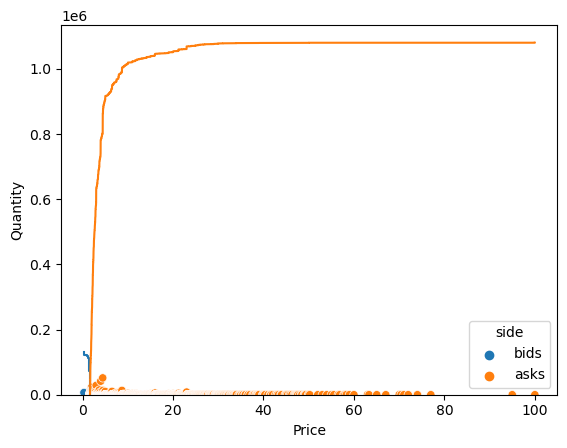

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

frames, data = get_order_book_depth(client, test_symbol)
fig, ax = plt.subplots()
sns.ecdfplot(x='price', weights='quantity', stat='count', complementary=True, data=frames['bids'], ax=ax)
sns.ecdfplot(x='price', weights='quantity', stat='count', data=frames['asks'], ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)
ax.set_xlabel('Price')
ax.set_ylabel('Quantity')
plt.show()

#### Screen market.

In [50]:
from utils.conversion import get_timezone_offset_in_seconds
from utils.conversion_table import get_conversion_table, get_tradable_tickers_info
from time import sleep

def loop_through_tickers(client, threshold=1e6):
    def filter_bid_ask_range_in_loop(symbol):
        sleep(2.9)
        return get_order_book_trigger(client=client, symbol=symbol, threshold=threshold)
    offset_s = get_timezone_offset_in_seconds()
    i = 0
    while True:
        conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                                offset_s=offset_s, as_pair=True, dump_raw=False, 
                                                minimal=True, extra_minimal=False, 
                                                convert_to_USDT=True, shortest_paths=shortest_paths)
        tickers_list = get_tradable_tickers_info(conversion_table=conversion_table)[1]
        print('len(tickers_list):', len(tickers_list))
        sleep(5)
        for j, symbol in enumerate(tickers_list):
            if filter_bid_ask_range_in_loop(symbol=symbol):
                print('#{}#{}: {} '.format(str(i), str(j), symbol), end='')
        i += 1

loop_through_tickers(client=client, threshold=1e5)

len(tickers_list): 133


KeyboardInterrupt: 

### Example testing the (as_pairs=True) bootstrapping of a minimal subset.

In [1]:
from utils.authentication import Cryptocurrency_authenticator
from utils.exchange import Cryptocurrency_exchange
from utils.conversion import get_timezone_offset_in_seconds
from utils.conversion import precompute_shortest_paths
from utils.conversion_table import get_conversion_table, get_new_tickers
from utils.conversion_ohlcv import convert_ohlcvs_from_pairs_to_assets
from utils.ohlcvs import download_pairs
from utils.resample import resample
from utils.volume_conversion import add_rolling_volumes
from tqdm import tqdm
import pandas as pd
import os
import shutil

def bootstrap_loggers(client, assets, pairs=None, additional_intervals=None, upsampled_intervals=None, 
                      download_interval='1m', exchange_info=None, as_pair=False, shortest_paths=None):
    log_file = 'crypto_logs/crypto_output_log_{}.txt'
    period = 2880 if download_interval == '1m' else 60
    second_period = 60 if download_interval == '1m' else None
    base_interval = download_interval + 'in' if download_interval[-1] == 'm' else download_interval
    frequency_1min = pd.tseries.frequencies.to_offset('1min')
    frequency_1d = pd.tseries.frequencies.to_offset('1d')
    frequency = pd.tseries.frequencies.to_offset(base_interval)
    pairs[base_interval] = download_pairs(client=client, assets=assets, interval=download_interval, 
                                          period=period, second_period=second_period)
    if not as_pair:
        pairs[base_interval] = convert_ohlcvs_from_pairs_to_assets(
            pairs[base_interval], exchange_info, shortest_paths=shortest_paths)
    pairs[base_interval] = add_rolling_volumes(pairs[base_interval])
    pairs[base_interval] = pairs[base_interval].loc[pairs[base_interval].dropna().first_valid_index():]
    #if additional_intervals is not None:
    #    for additional_interval in tqdm(additional_intervals, unit=' pair'):
    #        pairs[additional_interval] = resample(pairs[base_interval].copy(), interval=additional_interval)
    #        pairs[additional_interval] = pairs[additional_interval].tail(200)
    #        pairs[additional_interval].to_csv(log_file.format(additional_interval))
    #truncated_frequency = 60 if frequency > frequency_1min else 1500
    #pairs[base_interval] = pairs[base_interval].tail(truncated_frequency)
    #pairs[base_interval].to_csv(log_file.format(base_interval))
    #if upsampled_intervals is not None:
    #    for subminute_interval in tqdm(upsampled_intervals, unit=' pair'):
    #        pairs[subminute_interval] = pairs[base_interval].tail(25)
    #        pairs[subminute_interval] = pairs[subminute_interval].resample(subminute_interval).agg('max')
    #        pairs[subminute_interval] = pairs[subminute_interval].fillna(method='pad').tail(60)
    #        pairs[subminute_interval].to_csv(log_file.format(subminute_interval))
    return pairs

as_pair = False
directory = 'crypto_logs'

# Computing shortest_paths from scratch is expensive.
#if os.path.exists(directory):
#    shutil.rmtree(directory)
#os.mkdir(directory)

authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client
exchange = Cryptocurrency_exchange(client=client, directory=directory)
exchange_info = exchange.info

# Pre-compute shortest pair paths.
shortest_paths = precompute_shortest_paths(
    exchange_info, priority=None, 
    shortest_paths_file='crypto_logs/shortest_paths.pkl')

offset_s = get_timezone_offset_in_seconds()
conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                        offset_s=offset_s, as_pair=True, 
                                        shortest_paths=shortest_paths)
assets = get_new_tickers(conversion_table=conversion_table)
#assets = assets[:10]

pairs = bootstrap_loggers(client=client, assets=assets, pairs={}, 
                          additional_intervals=['30min'], 
                          upsampled_intervals=['5s', '15s'], 
                          download_interval='1m', 
                          exchange_info=exchange_info, 
                          #as_pair=True)
                          as_pair=False)
pairs['1min']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1376/1376 [17:36<00:00,  1.30 pair/s]
1376 named pair [03:12,  7.15 named pair/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1376/1376 [08:11<00:00,  2.80 pair/s]
1376 named pair [02:31,  9.11 named pair/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1376/1376 [00:05<00:00, 272.95 pair conversion/s]
1376 named pair [00:40, 33.90 named pair/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1376/1376 [00:04<00:00, 335.66 pair conversion/s]
1376 named pair [00:38, 35.87 named pair/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1376/1376 [00:00<00

  4%|████▊                                                                                                                         | 14/365 [00:00<00:10, 34.59 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

  8%|██████████▋                                                                                                                   | 31/365 [00:00<00:08, 37.72 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 13%|████████████████▌                                                                                                             | 48/365 [00:01<00:10, 30.40 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 18%|██████████████████████▍                                                                                                       | 65/365 [00:05<01:15,  3.97 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 22%|████████████████████████████▎                                                                                                 | 82/365 [00:06<00:22, 12.32 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 27%|██████████████████████████████████▏                                                                                           | 99/365 [00:06<00:10, 26.36 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 33%|████████████████████████████████████████▊                                                                                    | 119/365 [00:08<00:18, 13.07 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 38%|██████████████████████████████████████████████▉                                                                              | 137/365 [00:08<00:10, 22.71 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 42%|█████████████████████████████████████████████████████                                                                        | 155/365 [00:09<00:06, 33.28 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 47%|██████████████████████████████████████████████████████████▌                                                                  | 171/365 [00:09<00:05, 34.57 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 52%|████████████████████████████████████████████████████████████████▋                                                            | 189/365 [00:10<00:05, 35.11 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 205/365 [00:10<00:04, 33.10 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 222/365 [00:11<00:03, 36.76 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 239/365 [00:11<00:03, 38.62 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 71%|████████████████████████████████████████████████████████████████████████████████████████▎          

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 273/365 [00:12<00:02, 34.60 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 290/365 [00:13<00:02, 34.40 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 308/365 [00:13<00:01, 40.02 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████

/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 361/365 [00:17<00:00, 22.34 asset/s]/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'quote_volume')] = trading_quote_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:278: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed.loc[:, (asset, symbol, 'base_volume')] = trading_base_volume
/home/samuel/workspace/crypto_bot/utils/conversion_ohlcv.py:279: PerformanceWarning: indexing past lexsort depth may impact performance.
  conversion_table_mixed

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
feature,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-03-07 13:24:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:25:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:26:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:27:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,142.219400,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:28:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1805,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,745.673310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.064610e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09 13:48:00,0.462,71.3,0.0999,0.02742,2.518,0.3124,0.1782,2.534955e-10,0.35479,0.403,...,5.236280e+06,363736.339207,759277.039808,1.988318e+07,1.220100e+06,1.628430e+06,5.082390e+06,4.269299e+06,6.008929e+06,1.612886e+06
2023-03-09 13:49:00,0.462,71.2,0.0999,0.02724,2.518,0.3122,0.1782,2.540167e-10,0.35435,0.401,...,5.240776e+06,363685.301997,759258.468808,1.988101e+07,1.225927e+06,1.628356e+06,5.082373e+06,4.269092e+06,6.015066e+06,1.612886e+06


In [16]:
pairs = {}
pairs[base_interval] = pd.read_csv(log_file.format(base_interval), header=[0, 1], index_col=0, parse_dates=True)
pairs[base_interval]

symbol,1INCH,AAVE,ACA,ACH,ACM,ADA,ADX,AERGO,AGIX,AGLD,...,XTZ,XVG,XVS,YFI,YFII,YGG,ZEC,ZEN,ZIL,ZRX
feature,open,open,open,open,open,open,open,open,open,open,...,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume,rolling_quote_volume
date,,,,,,,,,,,,,,,,,,,,,
2023-03-07 13:24:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:25:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:26:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:27:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1803,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,142.219400,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-03-07 13:28:00,0.508,75.3,0.1126,0.02994,2.584,0.3281,0.1805,2.447316e-10,0.41402,0.433,...,0.000000e+00,0.000000,745.673310,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.064610e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09 13:48:00,0.462,71.3,0.0999,0.02742,2.518,0.3124,0.1782,2.534955e-10,0.35479,0.403,...,5.236280e+06,363736.339207,759277.039808,1.988318e+07,1.220100e+06,1.628430e+06,5.082390e+06,4.269299e+06,6.008929e+06,1.612886e+06
2023-03-09 13:49:00,0.462,71.2,0.0999,0.02724,2.518,0.3122,0.1782,2.540167e-10,0.35435,0.401,...,5.240776e+06,363685.301997,759258.468808,1.988101e+07,1.225927e+06,1.628356e+06,5.082373e+06,4.269092e+06,6.015066e+06,1.612886e+06


In [18]:
client=client
assets=assets
pairs={}
additional_intervals=['30min']
upsampled_intervals=['5s', '15s']
download_interval='1m'
exchange_info=exchange_info
as_pair=False
log_file = 'crypto_logs/crypto_output_log_{}.txt'
period = 2880 if download_interval == '1m' else 60
second_period = 60 if download_interval == '1m' else None
base_interval = download_interval + 'in' if download_interval[-1] == 'm' else download_interval
frequency_1min = pd.tseries.frequencies.to_offset('1min')
frequency_1d = pd.tseries.frequencies.to_offset('1d')
frequency = pd.tseries.frequencies.to_offset(base_interval)

pairs = {}
pairs[base_interval] = pd.read_csv(log_file.format(base_interval), header=[0, 1], index_col=0, parse_dates=True)
if additional_intervals is not None:
    for additional_interval in tqdm(additional_intervals, unit=' pair'):
        pairs[additional_interval] = resample(pairs[base_interval].copy(), interval=additional_interval)
        pairs[additional_interval] = pairs[additional_interval].tail(200)
        pairs[additional_interval].to_csv(log_file.format(additional_interval))
truncated_frequency = 60 if frequency > frequency_1min else 1500
pairs[base_interval] = pairs[base_interval].tail(truncated_frequency)
pairs[base_interval].to_csv(log_file.format(base_interval))
if upsampled_intervals is not None:
    for subminute_interval in tqdm(upsampled_intervals, unit=' pair'):
        pairs[subminute_interval] = pairs[base_interval].tail(25)
        pairs[subminute_interval] = pairs[subminute_interval].resample(subminute_interval).agg('max')
        pairs[subminute_interval] = pairs[subminute_interval].fillna(method='pad').tail(60)
        pairs[subminute_interval].to_csv(log_file.format(subminute_interval))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.89 pair/s]


In [7]:
import os
import pandas as pd
csv_path = 'crypto_logs/crypto_output_log_1min.txt'
#os.listdir('crypto_logs')
pairs['1min'].to_csv(csv_path)